# Exploratory Data Analysis (EDA) & Preprocessing

## Import Libraries

In [1]:
import eda_prep as ep
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

1. how many categories are in each folder
2. how many recordings in each category
3. Min/Max/Avg per category
4. Missing values
5. Find outliers
   1. per category
   2. visualizen

Feature Engineering
- Peak value
- Peak-to-peak value
- Amplitude
- Energy
- Frequency
- Peak-to-peak
- ARV: Average rectified value
- Weighted-ARV: 
- FFT: Frequency spektrum, different frequency parts (maybe)
   
Clustering

Data Augmentation

## Merge to df

In [2]:
def merge_geophone_falls(folder_path):
    """
    Merges all 'fall' data from CSV files in the given geophone folder.
    
    Parameters:
    - folder_path (str): Path to the geophone folder containing CSV files.
    
    Returns:
    - pd.DataFrame: Merged DataFrame with labeled columns.
    """
    all_data = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            parts = filename.split("_")
            
            if len(parts) < 5:
                print(f"Skipping file with unexpected format: {filename}")
                continue  # Skip files that don't match expected format
            
            fall_type = parts[0]  # First part of the filename
            fall_binary = parts[1]  # Check for fall keyword
            distance = parts[2]  # Third part of the filename
            person = parts[3]  # AW, AD, or 0
            floor_type = parts[-1].replace(".csv", "")  # Last part without ".csv"
            
            # Load CSV
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, header=None)
            
            # Take only the first 500 values
            # values = df.iloc[0, :500].tolist() if df.shape[1] >= 500 else df.iloc[0, :].tolist() + [None] * (500 - df.shape[1])
            for _, row in df.iterrows():
                # Ensure only 500 values are added
                values = row[:500].tolist() if len(row) >= 500 else row.tolist() + [None] * (500 - len(row))
                all_data.append([fall_type, fall_binary, distance, person, floor_type] + values)

    # Create DataFrame
    column_names = ["activity", "fall_binary", "distance_m", "person_binary", "floor"] + [f"value_{i}" for i in range(1, 501)]
    merged_df = pd.DataFrame(all_data, columns=column_names)

    return merged_df

# Example usage
df_geophone = merge_geophone_falls("../geophone")

## Add Additional Columns

### Add Weight Column

In [3]:
def add_weight_column(df):
    """
    Adds a new column 'weight' to the dataframe based on the person's identity and activity type.

    - 'AW' (Anna) -> 60kg
    - 'AD' (Adrian/David) -> 75kg
    - 'FOB' (Bag) -> 6kg
    - 'FOL' (Blackroll) -> 0.2kg

    Parameters:
    df (pd.DataFrame): Input dataframe containing 'person' and 'activity' columns.

    Returns:
    pd.DataFrame: Dataframe with the new 'weight' column.
    """
    # Mapping persons to their respective weights
    person_weight_map = {'AW': 60, 'AD': 75, '0': 0}

    # Insert weight column based on person mapping
    df.insert(4, 'weight', df['person_binary'].map(person_weight_map))

    # Update weight based on activity type
    df['weight'] = df.apply(lambda row: 
                            6 if row['activity'] == 'FOB' 
                            else (0.2 if row['activity'] == 'FOL' 
                                  else row['weight']), axis=1)
    
    return df

# Example usage:
df_geophone = add_weight_column(df_geophone)

### Map Person Column

In [4]:
def map_person_column(df, column_name='person_binary'):
    """
    Maps the 'person' column values to their numerical values.

    Parameters:
    - df (pd.DataFrame): Input dataframe containing 'person_binary' column.
    - column_name (str): Name of the column to be mapped.

    Returns:
    - pd.DataFrame: Dataframe with the mapped 'person' column.
    """
    df[column_name] = df[column_name].map({'AW': 1, 'AD': 1}).fillna(0).astype(int)
    return df

# Example usage:
df_geophone = map_person_column(df_geophone)

In [5]:
df_geophone.head()

,activity,fall_binary,distance_m,person_binary,weight,floor,value_1,value_2,value_3,value_4,...,value_491,value_492,value_493,value_494,value_495,value_496,value_497,value_498,value_499,value_500
0,FCS,1,1,1,75.0,H,59,-38,10,43,...,10,-8,-6,3,6,-5,10,10,-12,-6
1,FCS,1,1,1,75.0,H,104,-49,137,-46,...,-1,-15,-9,6,13,6,5,6,-4,-17
2,FCS,1,1,1,75.0,H,-11,48,-13,8,...,170,-107,-246,70,158,110,-52,-100,63,76
3,FCS,1,1,1,75.0,H,16,-11,22,4,...,2,-8,-13,0,13,1,-1,4,4,-9
4,FCS,1,1,1,75.0,H,5,-11,-4,2,...,36,12,2,13,8,7,9,-33,-11,-11


In [6]:
df_geophone.to_csv("merged_geophone_falls_raw.csv", index=False)

## Missing Values

In [7]:
df_geophone.isnull().sum().sum()

np.int64(0)

## Group By Activity

In [8]:
# group df_geophone by activity and count
df_geophone.groupby('activity').size()

activity
CD      20
FCS     60
FOB     60
FOL     60
KD      10
MA      45
RBS    120
S       45
SC      60
WBS     90
dtype: int64

## Group By Fall Binary

In [9]:
df_geophone.groupby('fall_binary').size()

fall_binary
0    510
1     60
dtype: int64

## Correct Data Types

In [10]:
df_geophone.dtypes

activity          object
fall_binary       object
distance_m        object
person_binary      int64
weight           float64
                  ...   
value_496          int64
value_497          int64
value_498          int64
value_499          int64
value_500          int64
Length: 506, dtype: object

In [11]:
def correct_data_types(df):
    """
    Corrects the data types of the columns in the dataframe.

    Parameters:
    - df (pd.DataFrame): Input dataframe.

    Returns:
    - pd.DataFrame: Dataframe with corrected data types.
    """
    df['fall_binary'] = df['fall_binary'].astype(int)
    df['distance_m'] = df['distance_m'].astype(float)
    df['floor'].astype(str)

# Example usage:
correct_data_types(df_geophone)
df_geophone.dtypes

activity          object
fall_binary        int64
distance_m       float64
person_binary      int64
weight           float64
                  ...   
value_496          int64
value_497          int64
value_498          int64
value_499          int64
value_500          int64
Length: 506, dtype: object

## Plot Average Signals by Activity

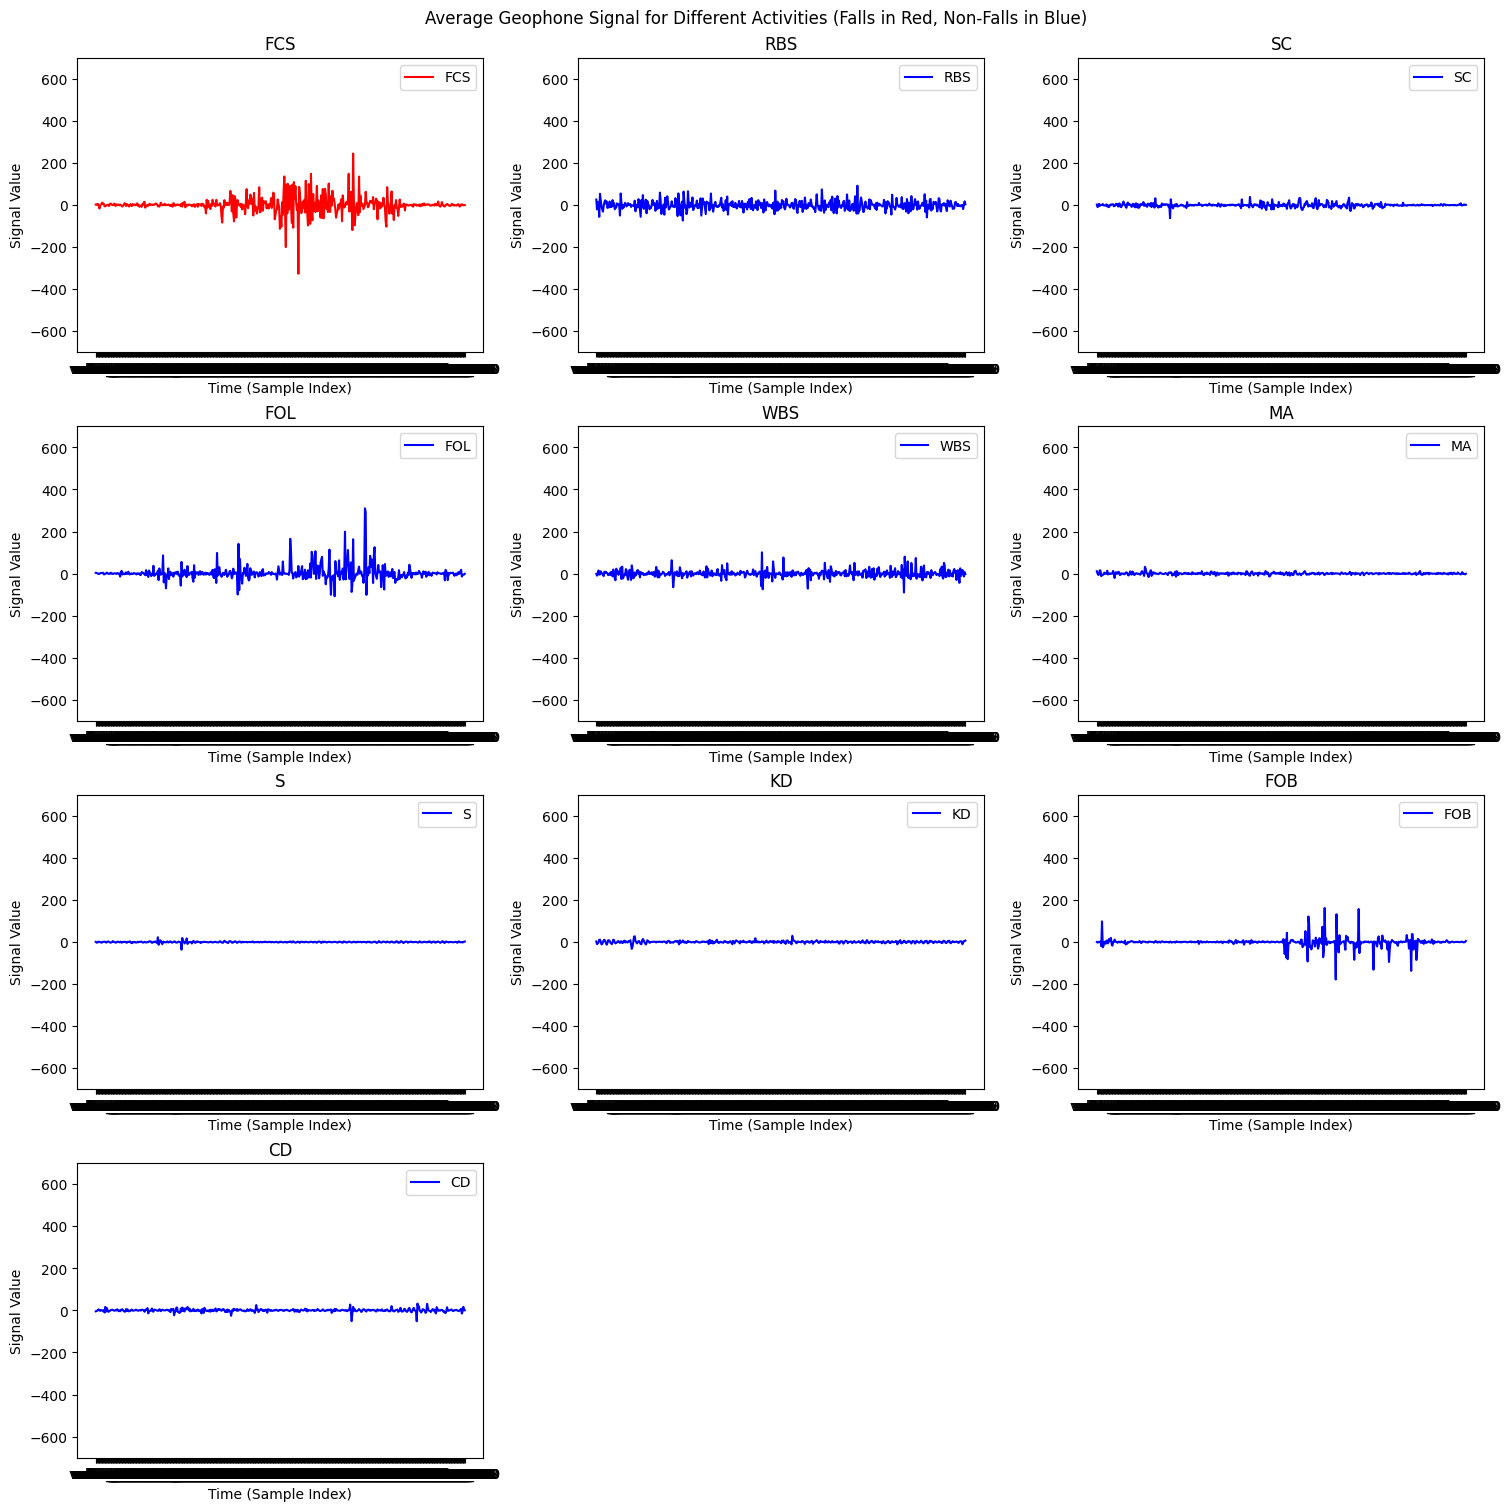

In [12]:
def plot_average_signals(df, hardware):
    """
    Plots the average geophone signal for each activity in the dataset.
    Falls are colored red, non-falls are blue.

    The mean signal is computed by summing all signals and dividing by the number of samples.

    Parameters:
    - df (pd.DataFrame): The input dataframe containing geophone data.
    - hardware (str): The hardware device used to collect the data.

    Returns:
    - None (Displays the plots)
    """
    # Get unique activities
    activities = df['activity'].unique()
    num_activities = len(activities)
    
    # Compute the number of rows and columns for the grid layout
    cols = 3  # Define the number of columns
    rows = (num_activities // cols) + (num_activities % cols > 0)

    # Compute global y-axis limits
    y_min, y_max = -700, 700

    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15), constrained_layout=True)
    axes = axes.flatten()  # Flatten to handle any number of subplots

    # Iterate over activities and plot
    for i, activity in enumerate(activities):
        ax = axes[i]
        
        # Get the fall_binary status for the current activity
        fall_status = df.loc[df['activity'] == activity, 'fall_binary'].values[0]  # Get first occurrence
        color = 'red' if fall_status == 1 else 'blue'

        # Filter the dataset for the current activity
        activity_data = df[df['activity'] == activity]

        # Compute the true mean signal (sum all signals and divide by sample count)
        total_signal = activity_data.iloc[:, 6:].sum(axis=0)
        num_samples = len(activity_data)
        mean_signal = total_signal / num_samples if num_samples > 0 else total_signal  # Avoid division by zero
        
        # Plot the average signal
        ax.plot(mean_signal, label=f"{activity}", color=color)
        ax.set_title(f"{activity}")
        ax.set_xlabel("Time (Sample Index)")
        ax.set_ylabel("Signal Value")
        ax.set_ylim(y_min, y_max)
        ax.legend()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f"Average {hardware} Signal for Different Activities (Falls in Red, Non-Falls in Blue)")
    plt.show()

# Example usage:
plot_average_signals(df_geophone, 'Geophone')

## Add Feature Columns

In [13]:
def add_features(df):
    """
    Adds features of signal data for each row.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing signal data.
    - sampling_interval (float): The time interval between each sample.

    Returns:
    - pd.DataFrame: The DataFrame with the new features.
    """
    # Signal data starts from column index 6
    signal_columns = df.columns[6:]

    # Sampling interval (in seconds)
    sampling_interval=4.5/500

    # Compute values
    df['max'] = df[signal_columns].max(axis=1) # Compute max value
    df['min'] = df[signal_columns].min(axis=1) # Compute min value
    df['mean'] = df[signal_columns].mean(axis=1) # Compute mean value
    df['std'] = df[signal_columns].std(axis=1) # Compute standard deviation
    df['median'] = df[signal_columns].median(axis=1) # Compute median value
    df['peak'] = df[signal_columns].abs().max(axis=1) # Compute peak value
    df['p2p'] = df['max'] - df['min'] # Compute peak-to-peak value (range)
    df['energy'] = df['peak'] * sampling_interval # Compute energy using numerical integration (Riemann sum approximation)
    df['rms'] = df['std'] / (2 ** 0.5) # Compute root mean square
    df['crest'] = df['peak'] / df['rms'] # Compute crest factor
    df['shape'] = df['peak'] / df['mean'] # Compute shape factor
    df['impulse'] = df['peak'] * sampling_interval / df['mean'] # Compute impulse factor
    df['margin'] = df['peak'] / (df['mean'] + 1e-10) # Compute margin factor

    return df

# Example usage:
df_geophone = add_features(df_geophone)
df_geophone.head()

,activity,fall_binary,distance_m,person_binary,weight,floor,value_1,value_2,value_3,value_4,...,std,median,peak,p2p,energy,rms,crest,shape,impulse,margin
0,FCS,1,1.0,1,75.0,H,59,-38,10,43,...,332.233428,0.0,3335,6239,30.015,234.924510,14.196050,-265.229839,-2.387069,-265.229839
1,FCS,1,1.0,1,75.0,H,104,-49,137,-46,...,332.036962,-1.0,5425,7219,48.825,234.785588,23.106188,-347.266675,-3.125400,-347.266675
2,FCS,1,1.0,1,75.0,H,-11,48,-13,8,...,556.031918,2.0,8664,13197,77.976,393.173940,22.036048,389.288282,3.503595,389.288282
3,FCS,1,1.0,1,75.0,H,16,-11,22,4,...,467.826539,0.0,8603,10514,77.427,330.803318,26.006390,443.499330,3.991494,443.499330
4,FCS,1,1.0,1,75.0,H,5,-11,-4,2,...,782.252039,1.0,13943,20184,125.487,553.135722,25.207195,-772.037652,-6.948339,-772.037652


## Features by Activity

In [14]:
def add_features_grouped(df):
    """
    Computes signal features and returns the average values grouped by activity, 
    fall_binary, person_binary, floor, and distance_m.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing signal data.

    Returns:
    - pd.DataFrame: A DataFrame with the computed features averaged by the specified grouping columns.
    """
    # Identify numeric columns (excluding group columns)
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    
    # Ensure signal data is numeric
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Keep grouping columns
    df['activity'] = df['activity']
    df['distance_m'] = df['distance_m']

    # Signal data starts from column index 6
    signal_columns = df.columns[6:]

    # Sampling interval (in seconds)
    sampling_interval = 4.5 / 500

    # Compute features for each row
    df['max'] = df[signal_columns].max(axis=1)
    df['min'] = df[signal_columns].min(axis=1)
    df['mean'] = df[signal_columns].mean(axis=1)
    df['std'] = df[signal_columns].std(axis=1)
    df['median'] = df[signal_columns].median(axis=1)
    df['peak'] = df[signal_columns].abs().max(axis=1)
    df['p2p'] = df['max'] - df['min']
    df['energy'] = df['peak'] * sampling_interval
    df['rms'] = df['std'] / (2 ** 0.5)
    df['crest'] = df['peak'] / df['rms']
    df['shape'] = df['peak'] / df['mean']
    df['impulse'] = df['peak'] * sampling_interval / df['mean']
    df['margin'] = df['peak'] / (df['mean'] + 1e-10)

    # Ensure only numeric feature columns are included in the mean calculation
    feature_columns = [col for col in df.columns if col not in ['activity', 'floor', 'fall_binary', 'person_binary', 'distance_m', 'weight'] and df[col].dtype in ['int64', 'float64']]

    # Group by multiple columns and compute the mean for each numeric feature
    grouped_df = df.groupby(["activity", "fall_binary", "person_binary", "floor", "distance_m", "weight"])[feature_columns].mean().reset_index()

    return grouped_df

# Example usage:
df_geophone_grouped_by_activity = add_features_grouped(df_geophone)
df_geophone_grouped_by_activity

,activity,fall_binary,person_binary,floor,distance_m,weight,value_1,value_2,value_3,value_4,...,std,median,peak,p2p,energy,rms,crest,shape,impulse,margin
0,CD,0,0,H,2.0,0.0,-4.250000,-3.000000,-2.000000,3.100000,...,73.570516,0.294550,826.110246,1148.210246,7.434992,52.022211,15.087561,30.116347,0.271047,30.116347
1,FCS,1,1,H,1.0,60.0,21.300000,21.500000,-11.800000,20.500000,...,763.422094,0.200000,8823.700000,12704.000000,79.413300,539.820939,16.157354,219.676921,1.977092,219.676921
2,FCS,1,1,H,1.0,75.0,13.700000,-1.800000,27.800000,8.100000,...,932.056152,0.600000,10936.300000,15748.800000,98.426700,659.063225,16.490107,297.459254,2.677133,297.459254
3,FCS,1,1,H,2.0,60.0,10.800000,-0.800000,-3.000000,-3.000000,...,341.398343,0.600000,3945.900000,6098.200000,35.513100,241.405084,15.917189,-780.002242,-7.020020,-780.002242
4,FCS,1,1,H,2.0,75.0,-2.200000,-2.900000,2.900000,8.000000,...,370.192940,0.000000,4294.500000,6369.500000,38.650500,261.765938,16.063440,258.783076,2.329048,258.783076
5,FCS,1,1,H,3.0,60.0,-7.000000,-1.300000,-3.200000,-1.800000,...,62.848067,0.700000,658.660466,961.032122,5.927944,44.440294,14.467425,-404.260328,-3.638343,-404.260329
6,FCS,1,1,H,3.0,75.0,-18.300000,9.300000,-6.500000,1.900000,...,152.868568,0.899105,1616.501235,2698.401235,14.548511,108.094401,14.850144,367.518120,3.307663,367.518120
7,FOB,0,0,H,1.0,6.0,1.000000,-3.700000,0.800000,3.400000,...,588.366223,0.300000,6962.674976,10263.424976,62.664075,416.037746,16.431251,137363.842499,1236.274582,137363.829523
8,FOB,0,0,H,2.0,6.0,-1.550000,-2.800000,-3.400000,-2.000000,...,219.529555,0.487354,2518.857545,3577.757545,22.669718,155.230837,15.875415,654.958997,5.894631,654.958996
9,FOB,0,0,H,3.0,6.0,0.700000,-1.800000,-1.250000,0.950000,...,582.594769,0.582850,7473.958936,7802.357129,67.265630,411.956712,15.015740,-16.424944,-0.147824,-16.424945


## Outliers

In [15]:
# find outliers for the dataframe df_geophone
def find_outliers(df):
    """
    Finds outliers in the DataFrame using the Tukey method.

    Parameters:
    - df (pd.DataFrame): The DataFrame to find outliers in.

    Returns:
    - pd.DataFrame: A DataFrame containing the outliers.
    """
    # Identify numeric columns
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

    # Ensure signal data is numeric
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Compute Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)

    # Compute IQR (Interquartile Range)
    IQR = Q3 - Q1

    # Compute lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df[((df[numeric_columns] < lower_bound) | (df[numeric_columns] > upper_bound)).any(axis=1)]

    return outliers

# Example usage:
outliers_geophone = find_outliers(df_geophone)
outliers_geophone

,activity,fall_binary,distance_m,person_binary,weight,floor,value_1,value_2,value_3,value_4,...,std,median,peak,p2p,energy,rms,crest,shape,impulse,margin
0,FCS,1,1.0,1,75.0,H,59,-38,10,43,...,546.264951,0.0,6239.0,9143.0,56.1510,386.267651,16.152013,478.563363,4.307070,478.563363
1,FCS,1,1.0,1,75.0,H,104,-49,137,-46,...,653.342483,-1.0,7219.0,12644.0,64.9710,461.982900,15.626119,565.269369,5.087424,565.269369
2,FCS,1,1.0,1,75.0,H,-11,48,-13,8,...,1078.499754,3.0,13197.0,17730.0,118.7730,762.614489,17.304943,155.602988,1.400427,155.602988
3,FCS,1,1.0,1,75.0,H,16,-11,22,4,...,890.353362,0.0,10514.0,12425.0,94.6260,629.574900,16.700158,137.483621,1.237353,137.483621
4,FCS,1,1.0,1,75.0,H,5,-11,-4,2,...,1716.947126,1.0,20184.0,34127.0,181.6560,1214.064956,16.625140,331.276957,2.981493,331.276957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,FOB,0,1.0,0,6.0,H,-5,-13,8,-3,...,199.299069,0.0,2295.0,3204.0,20.6550,140.925723,16.285175,148.258816,1.334329,148.258816
566,FOB,0,1.0,0,6.0,H,1,-25,-5,37,...,605.569845,0.0,6304.0,12070.0,56.7360,428.202544,14.722005,976.496843,8.788472,976.496843
567,FOB,0,1.0,0,6.0,H,-2,5,-1,-6,...,1044.968446,0.0,13687.5,13906.5,123.1875,738.904275,18.524050,169.006951,1.521063,169.006951
568,FOB,0,1.0,0,6.0,H,8,-2,21,-9,...,673.376463,1.0,7388.0,9014.0,66.4920,476.149063,15.516149,126.450455,1.138054,126.450455


## Scatterplots

In [16]:
def plot_scatter(df, x_value, y_value, labels=False):
    """
    Creates a scatter plot with x_value on the x-axis, y_value on the y-axis,
    and colors based on the activity category.
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - x_value (str): Column name for x-axis.
    - y_value (str): Column name for y-axis.
    - labels (bool): Whether to annotate points with recording labels.
    """
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(
        data=df, x=x_value, y=y_value, hue="activity",
        palette="tab10", alpha=0.8, edgecolor="black"
    )
    
    # Labels and title
    plt.xlabel(x_value)
    plt.ylabel(y_value)
    plt.title(f"Scatter Plot of {x_value} vs {y_value} Colored by Activity")
    
    # Add annotations if labels=True
    if labels:
        for _, row in df.iterrows():
            plt.annotate(
                row['activity'], 
                (row[x_value], row[y_value]), 
                fontsize=8, alpha=0.7
            )
    
    # Adjust legend
    plt.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.show()

### Mean & Std

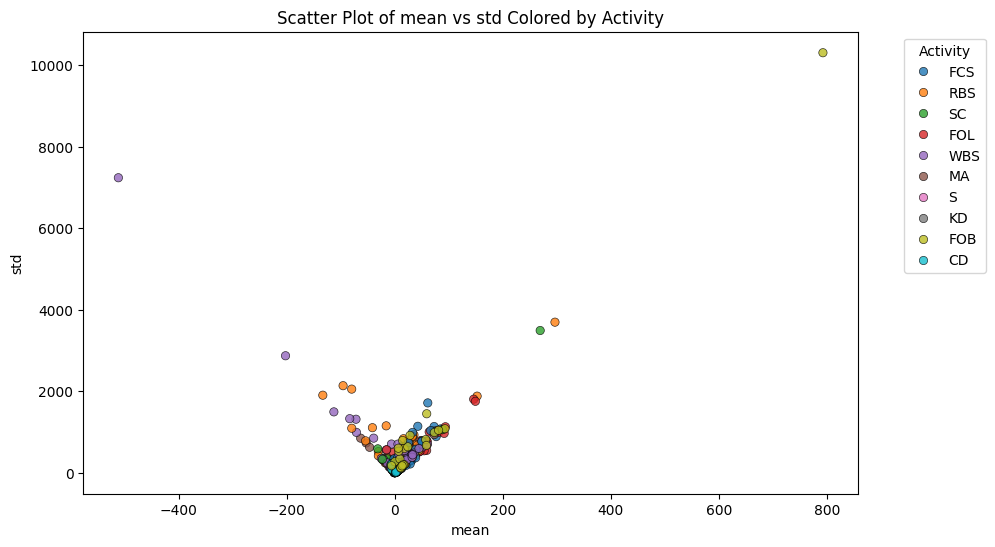

In [17]:
plot_scatter(df_geophone, "mean", "std", labels=False)

### Peak & P2P

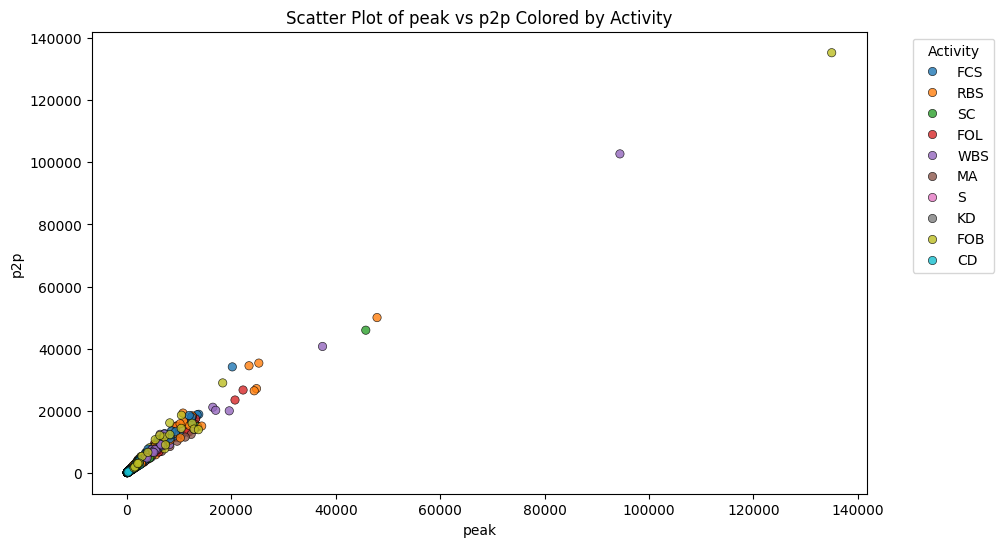

In [18]:
plot_scatter(df_geophone, "peak", "p2p", labels=False)

### Energy & RMS

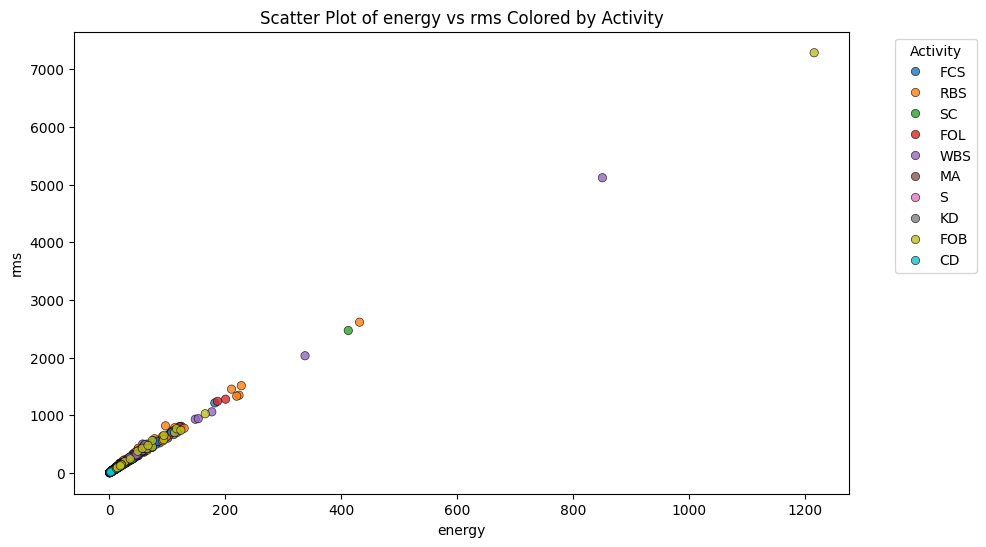

In [19]:
plot_scatter(df_geophone, "energy", "rms", labels=False)

### Crest & Shape

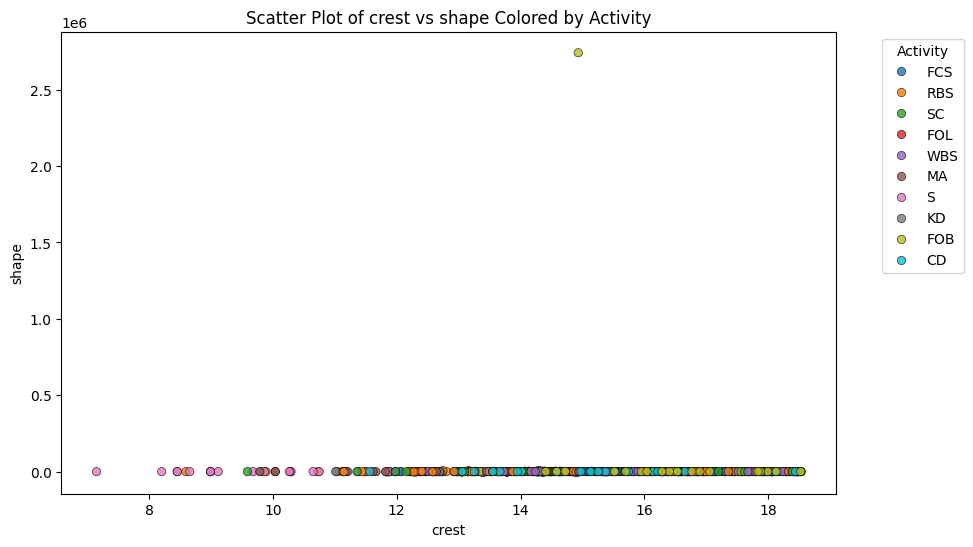

In [20]:
plot_scatter(df_geophone, "crest", "shape", labels=False)

### Std & RMS

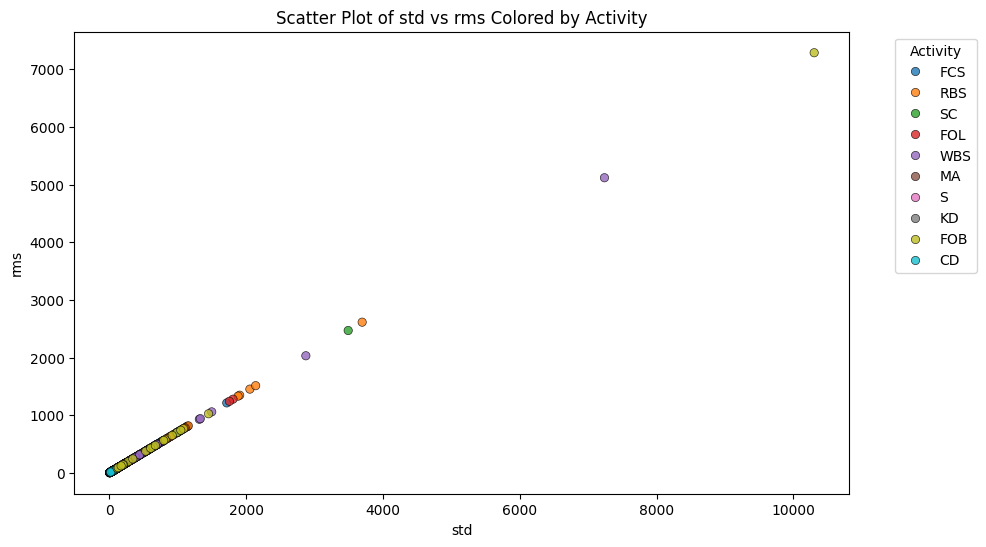

In [21]:
plot_scatter(df_geophone, "std", "rms", labels=False)

### P2P & Impulse

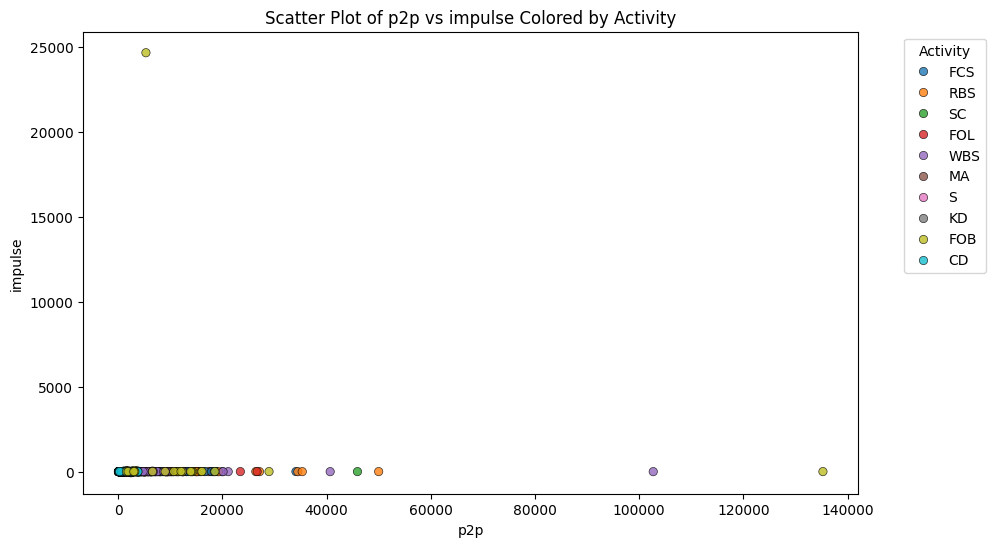

In [22]:
plot_scatter(df_geophone, "p2p", "impulse", labels=False)